In [2]:
import pandas as pd
from PIL import Image, PngImagePlugin
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
import pytorch_lightning as pl
import torch
from torch import nn
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics.classification import Accuracy
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

PngImagePlugin.MAX_TEXT_CHUNK = int(1e15)

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
df = pd.read_parquet('../new_images_path_all.parquet.gzip')
len(df)

26974

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = row['Id_typology']
        img = Image.open(f"/home/jupyter/datasphere/project/{row['Img_folder']}/{row['Img_path']}")
        
        if self.transform:
            img = self.transform(img)
        return img, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [23]:
BATCH_SIZE = 1024

dataset = ImageDataset(df, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [0.75, 0.25])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

logger = TensorBoardLogger("double_learn_logs", name="resnet")

In [5]:
class ImageClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights="DEFAULT")
        self.model.fc = nn.Linear(self.model.fc.in_features, 15)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=15)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=15)
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        accuracy = self.accuracy(outputs, labels)
        logs = {'loss': loss, 'accuracy': accuracy}
        self.log_dict(logs, logger=True)
        return logs
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels.view(-1))
        accuracy = self.val_accuracy(outputs, labels)
        logs = {"val_loss": loss, "val_accuracy": accuracy}
        self.log_dict(logs, logger=True)
        return logs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [25]:
model = ImageClassifier()

In [26]:
for param in model.model.parameters():
    param.requires_grad_(False)
model.model.fc.requires_grad_(True)

Linear(in_features=512, out_features=15, bias=True)

In [ ]:
trainer = pl.Trainer(
    max_epochs=80,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=logger,
    log_every_n_steps=20,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)],
    enable_checkpointing=True
)

trainer.fit(model, train_loader, val_loader)
# trainer.save_checkpoint("final.ckpt")
# trainer.fit(model, train_loader, val_loader, ckpt_path="./transfer_learn_logs/resnet/version_0/checkpoints/epoch=7-step=1272.ckpt")

In [7]:
model = ImageClassifier.load_from_checkpoint("/home/jupyter/datasphere/project/MODEL/double_learn_logs/resnet/version_3/checkpoints/epoch=7-step=160.ckpt")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 66.8MB/s]


In [10]:
BATCH_SIZE = 512

dataset = ImageDataset(df, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [0.75, 0.25])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

logger = TensorBoardLogger("double_learn_logs", name="resnet")

In [11]:
for param in model.model.parameters():
    param.requires_grad_(True)

In [ ]:
trainer = pl.Trainer(
    max_epochs=80,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=logger,
    log_every_n_steps=40,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)],
    enable_checkpointing=True
)

trainer.fit(model, train_loader, val_loader)
# trainer.save_checkpoint("final.ckpt")
# trainer.fit(model, train_loader, val_loader, ckpt_path="./transfer_learn_logs/resnet/version_0/checkpoints/epoch=7-step=1272.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | ResNet             | 11.2 M | train
1 | criterion    | CrossEntropyLoss   | 0      | train
2 | accuracy     | MulticlassAccuracy | 0      | train
3 | val_accuracy | MulticlassAccuracy | 0      | train
------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.737    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Epoch 2: 100%|██████████| 40/40 [09:52<00:00,  0.07it/s, v_num=4]          
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 40/40 [09:44<00:00,  0.07it/s, v_num=4]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 40/40 [09:23<00:00,  0.07it/s, v_num=4]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:  10%|█         | 4/40 [00:52<07:50,  0.08it/s, v_num=4]        


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [13]:
trained_model = ImageClassifier.load_from_checkpoint("/home/jupyter/datasphere/project/MODEL/double_learn_logs/resnet/version_4/checkpoints/epoch=4-step=200.ckpt")
trained_model.eval()
trained_model = trained_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [21]:
torch_model = trained_model.to_torchscript(method="trace", example_inputs=torch.randn(1, 3, 224, 224))

In [15]:
from tqdm import tqdm
y_true = []
y_pred = []
for (X_batch, y_batch) in tqdm(val_loader):
    pred = trained_model(X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    y_true += y_batch.tolist()
    y_pred += pred.tolist()


100%|██████████| 14/14 [03:39<00:00, 15.67s/it]


In [17]:
import numpy as np
y_pred_np = np.array(y_pred).argmax(axis=1)
y_true_np = np.array(y_true)

In [18]:
type_id = pd.read_parquet('../new_type_id.parquet.gzip')

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import seaborn as sns

def draw_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=type_id['typology'], yticklabels=type_id['typology'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Epoch 0:   5%|▌         | 4/80 [1:21:17<25:44:41,  0.00it/s, v_num=4]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92653841f0>
Traceback (most recent call last):
  File "/home/jupyter/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jupyter/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


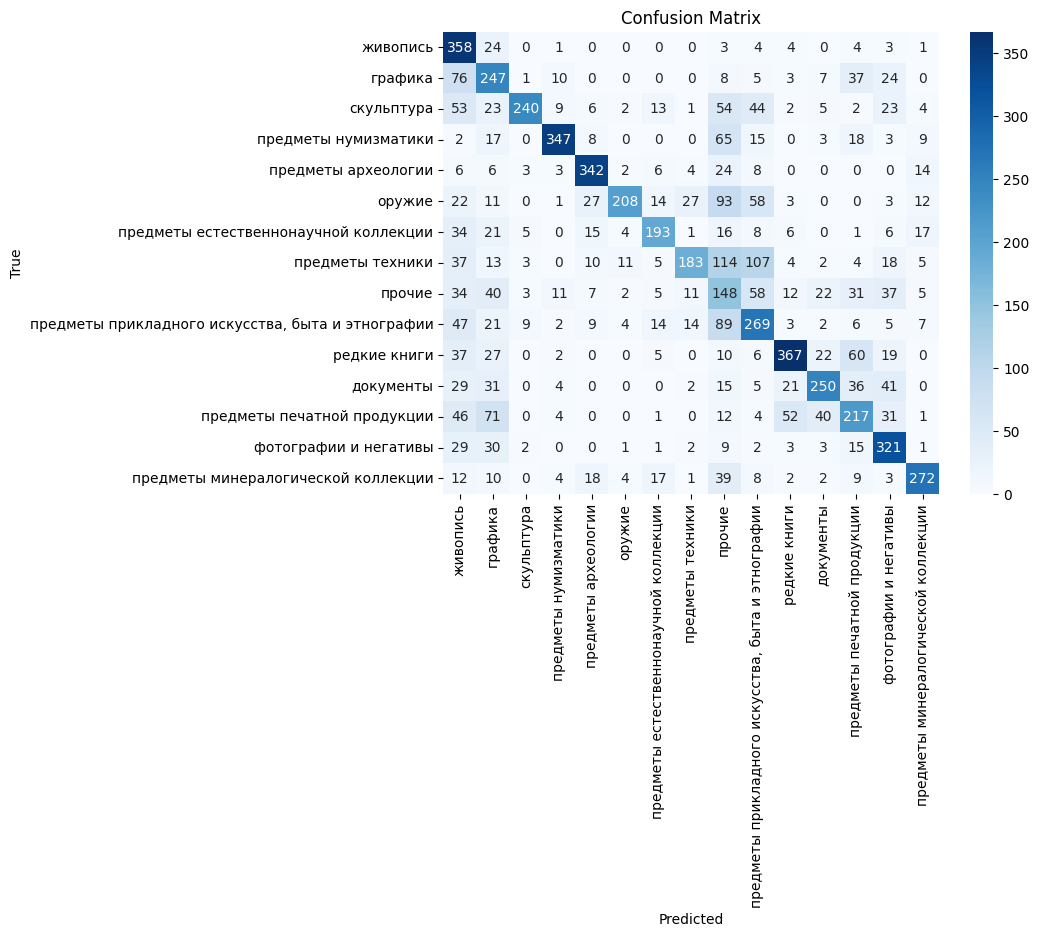

In [20]:
draw_confusion_matrix(y_true_np, y_pred_np)